In [1]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Loading database

df_train = pd.read_csv("dataset/UNSW_NB15_training-set.csv", low_memory=False)
df_test = pd.read_csv("dataset/UNSW_NB15_testing-set.csv", low_memory=False)

df_train = df_train.drop("id", axis=1)
df_test = df_test.drop("id", axis=1)


In [3]:
# Visualizing df (train) info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [4]:

df_train.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
df_test.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
# Object (categoric) columns

cat_cols = df_train.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')


In [7]:
# Selecting columns
X_train = df_train.iloc[:, :-1]
y_train = df_train['label']

X_test = df_test.iloc[:, :-1]
y_test = df_test['label']


In [8]:
# Visualizing columns from df(train)
cat_cols_train = X_train.select_dtypes(include=['object']).columns
num_cols_train = X_train.select_dtypes(exclude=['object']).columns
print(f"Categoric columns: {len(cat_cols_train)}")
print(f"Numeric columns: {len(num_cols_train)}")

Categoric columns: 4
Numeric columns: 39


In [9]:
# Visualizing columns from df(test)
cat_cols_test = X_test.select_dtypes(include=['object']).columns
num_cols_test = X_test.select_dtypes(exclude=['object']).columns
print(f"Categoric columns: {len(cat_cols_train)}")
print(f"Numeric columns: {len(num_cols_train)}")

Categoric columns: 4
Numeric columns: 39


In [10]:
normal = df_train.loc[df_train["label"] == 0]
malicious = df_train.loc[df_train["label"] == 1]

normal_test = df_test.loc[df_test["label"] == 0]
malicious_test = df_test.loc[df_test["label"] == 1]

print(f"There is {len(normal)} normal traffic and {len(malicious)} malicious traffic (train data)")
print(
    f"There is {len(normal_test)} normal traffic and {len(malicious_test)} malicious traffic (test data)")

There is 56000 normal traffic and 119341 malicious traffic (train data)
There is 37000 normal traffic and 45332 malicious traffic (test data)


In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline


preprocessor_train = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_train),
        ('num', RobustScaler(), num_cols_train)
    ]
)

pipeline_train = Pipeline(steps=[
    ('preprocessor', preprocessor_train)
])

X_train_transformed = pipeline_train.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

X_test_transformed = pipeline_train.transform(X_test)


print(f"Shape dos dados de treino após SMOTE: {X_resampled.shape}")
print(f"Shape dos dados de teste após transformação: {X_test_transformed.shape}")

Shape dos dados de treino após SMOTE: (238682, 204)
Shape dos dados de teste após transformação: (82332, 204)


In [12]:


X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

X_train_resampled = X_train_resampled.astype(np.float32).toarray()
X_val_resampled = X_val_resampled.astype(np.float32).toarray()

y_train_resampled = y_train_resampled.astype(np.float32)
y_val_resampled = y_val_resampled.astype(np.float32)

X_test_transformed = X_test_transformed.astype(np.float32).toarray()
y_test_transformed = y_test.astype(np.float32)

print(f"Train length: {X_train_resampled.shape}")
print(f"Val length: {X_val_resampled.shape}")

print(f"Test length: {X_test_transformed.shape}")

Train length: (167077, 204)
Val length: (71605, 204)
Test length: (82332, 204)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:


batch_size = 64





train_data = TensorDataset(torch.tensor(X_train_resampled, dtype=torch.float32).to(device),




                           torch.tensor(y_train_resampled, dtype=torch.float32).view(-1, 1).to(device))




test_data = TensorDataset(torch.tensor(X_test_transformed, dtype=torch.float32).to(device),




                          torch.tensor(y_test_transformed, dtype=torch.float32).view(-1, 1).to(device))





train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)




test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [15]:
import torch
import torch.nn as nn


class MainNetwork(nn.Module):
    def __init__(self):
        super(MainNetwork, self).__init__()

        self.fc1 = nn.Linear(204, 204)
        self.fc2 = nn.Linear(204, 36)
        self.fc3 = nn.Linear(36, 24)
        self.fc4 = nn.Linear(24, 12)
        self.fc5 = nn.Linear(12, 1)

    
        self.bn1 = nn.BatchNorm1d(204)  
        self.bn2 = nn.BatchNorm1d(36)  
        self.bn3 = nn.BatchNorm1d(24)  
        self.bn4 = nn.BatchNorm1d(12) 

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.bn1(self.relu(self.fc1(x))) 
        x = self.dropout(x)

        x = self.bn2(self.relu(self.fc2(x)))  
        x = self.dropout(x)

        x = self.bn3(self.relu(self.fc3(x)))  
        x = self.dropout(x)

        x = self.bn4(self.relu(self.fc4(x)))  
        x = self.dropout(x)

        x = self.fc5(x)

        return x

In [38]:
# Model, loss function and optimizer

model = MainNetwork().to(device)
pos_weight = torch.tensor([10.0]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=0.000001, weight_decay=1e-4)

In [39]:
epochs = 130

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for inputs, labels in train_loader: 
        inputs, labels = inputs.to(device), labels.to(
            device).float().view(-1, 1)

        optimizer.zero_grad()

        y_pred = model(inputs)

        loss = criterion(y_pred, labels)

        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(y_pred)

        predicted = (probs > 0.5).float()
        
        correct = (predicted == labels).float()
        acc = correct.sum() / len(correct)

        running_loss += loss.item()
        running_acc += acc.item()

    avg_loss = running_loss / len(train_loader)
    avg_acc = running_acc / len(train_loader)

    print(
        f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_acc * 100:.2f}%")

Epoch [1/130], Loss: 7.7192, Accuracy: 50.65%
Epoch [2/130], Loss: 7.5489, Accuracy: 52.01%
Epoch [3/130], Loss: 7.3801, Accuracy: 53.46%
Epoch [4/130], Loss: 7.2480, Accuracy: 54.71%
Epoch [5/130], Loss: 7.0996, Accuracy: 55.84%
Epoch [6/130], Loss: 7.0119, Accuracy: 56.72%
Epoch [7/130], Loss: 6.9142, Accuracy: 57.83%
Epoch [8/130], Loss: 6.8370, Accuracy: 58.41%
Epoch [9/130], Loss: 6.7328, Accuracy: 59.31%
Epoch [10/130], Loss: 6.6473, Accuracy: 60.34%
Epoch [11/130], Loss: 6.5857, Accuracy: 61.12%
Epoch [12/130], Loss: 6.5185, Accuracy: 61.79%
Epoch [13/130], Loss: 6.4419, Accuracy: 62.71%
Epoch [14/130], Loss: 6.3573, Accuracy: 63.49%
Epoch [15/130], Loss: 6.3114, Accuracy: 64.16%
Epoch [16/130], Loss: 6.2325, Accuracy: 65.11%
Epoch [17/130], Loss: 6.1617, Accuracy: 65.82%
Epoch [18/130], Loss: 6.0976, Accuracy: 66.57%
Epoch [19/130], Loss: 6.0046, Accuracy: 67.54%
Epoch [20/130], Loss: 5.9564, Accuracy: 68.11%
Epoch [21/130], Loss: 5.8898, Accuracy: 68.70%
Epoch [22/130], Loss: 

In [40]:
# Testing
model.eval()

with torch.no_grad():
    test_loss = 0.0
    test_acc = 0.0
    y_pred_test = []
    y_true_test = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(
            device).float().view(-1, 1)

        y_pred = model(inputs)

        loss = criterion(y_pred, labels)
        test_loss += loss.item()

        probs = torch.sigmoid(y_pred) 

        predicted = (probs > 0.5).float()

        correct = (predicted == labels).float()
        acc = correct.sum() / len(correct)
        test_acc += acc.item()


        y_pred_test.extend(predicted.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())


    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)

    print(
        f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc * 100:.2f}%")

Test Loss: 0.8882, Test Accuracy: 97.08%


In [41]:
y_pred_test = np.array(y_pred_test).flatten()
y_true_test = np.array(y_true_test).flatten()

In [42]:

false_neg = np.sum((y_pred_test == 0) & (y_true_test == 1))
false_pos = np.sum((y_pred_test == 1) & (y_true_test == 0))
incorrect = np.sum(y_pred_test != y_true_test)
total = len(y_true_test)

accuracy = accuracy_score(y_true_test, y_pred_test)
inaccuracy = incorrect / total

print(f'Accuracy: {accuracy * 100:.4f}%')
print(f'Incorrect: {inaccuracy * 100:.4f}%')
print(f'False negatives: {false_neg / incorrect:.4f}')
print(f'False positives: {false_pos / incorrect:.4f}')
print(f'False negatives/total: {false_neg / total:.4f}')


Accuracy: 97.0801%
Incorrect: 2.9199%
False negatives: 0.2092
False positives: 0.7908
False negatives/total: 0.0061


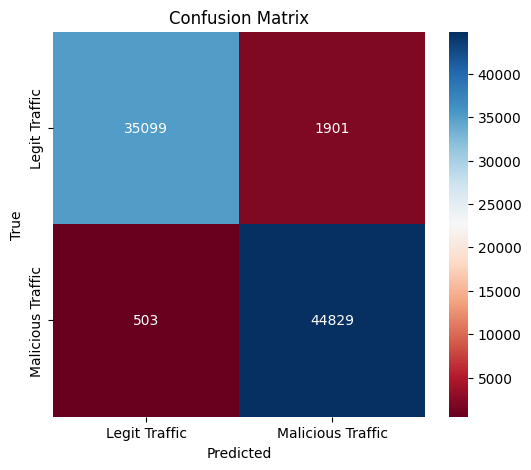

In [43]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu', xticklabels=[
            'Legit Traffic', 'Malicious Traffic'], yticklabels=['Legit Traffic', 'Malicious Traffic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
torch.save(model.state_dict(), "model.pth")